In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import os

In [4]:
import platform

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

Use the code block below to access the Two-Photon Calcium Imaging data set.  This is what we used in the tutorials.

In [5]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

Use code below to access Neuropixels data set.  This is electrophysiological data.  It is very similar to the data set we demonstrated, but has important differences, both in the science and in the access methods used in the python tools.

In [6]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
visual_areas = ["VISp"]
cre_lines = [""]
imaging_depths = [""]

experiments = boc.get_experiment_containers(targeted_structures=visual_areas)

experiment_container_id = experiments[0]["id"]

In [10]:
stimuli = ["static_gratings"]

session = boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id], stimuli=stimuli)[0]

data_set = boc.get_ophys_experiment_data(session["id"])

In [11]:
cell_ids = data_set.get_cell_specimen_ids()

cell_ids

array([673033275, 673031753, 673033511, 673033518, 673032606, 673032589,
       673032709, 673032160, 673033184, 673033807, 673033301, 673033198,
       673033191, 673033635, 673033086, 673033504, 673033497, 673033357,
       673031738, 673033490, 673033476, 673033469, 673033378, 673032947,
       673032968, 673033146, 673033656, 673032975, 673033219, 673033226,
       673033569, 673033663, 673032409, 673033067, 673031481, 673033212,
       673033233, 673033649, 673031951, 673033689, 673032041, 673032027,
       673031987, 673031910, 673033455, 673032005, 673031631, 673033247,
       673033268, 673033254, 673032235, 673032528, 673032933, 673032519,
       673032914, 673031938, 673031977, 673031608, 673031576, 673032208,
       673031592, 673032283, 673032195, 673031655, 673033614, 673033289,
       673032655, 673032672, 673031684, 673031698, 673032687, 673033642,
       673033163, 673033170, 673032735, 673032174, 673032268, 673033177,
       673033116, 673032360, 673033060, 673031533, 

In [17]:
?data_set.get_stimulus_table

Signature: data_set.get_stimulus_table(stimulus_name)
Docstring:
Return a stimulus table given a stimulus name 

Notes
-----
For more information, see:
http://help.brain-map.org/display/observatory/Documentation?preview=/10616846/10813485/VisualCoding_VisualStimuli.pdf 
File:      /opt/conda/lib/python3.8/site-packages/allensdk/core/brain_observatory_nwb_data_set.py
Type:      method


In [29]:

# def get_cell_mean_responses(cell_id, stimulus="static_gratings"):
#     """get the cell's mean responses to each epoch of a given stimulus"""

# get cell indices
cell_indices = data_set.get_cell_specimen_indices(cell_ids)

# get dff traces for all cells
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=cell_ids) # get cell responses in the dataset
    
# get stimulus table and stimulus epochs
stim_table = data_set.get_stimulus_table("static_gratings")
stim_table = stim_table[stim_table["orientation"].isna() == False] # remove blank sweep readings

# get stimulus epochs
stim_epochs = data_set.get_stimulus_epoch_table()

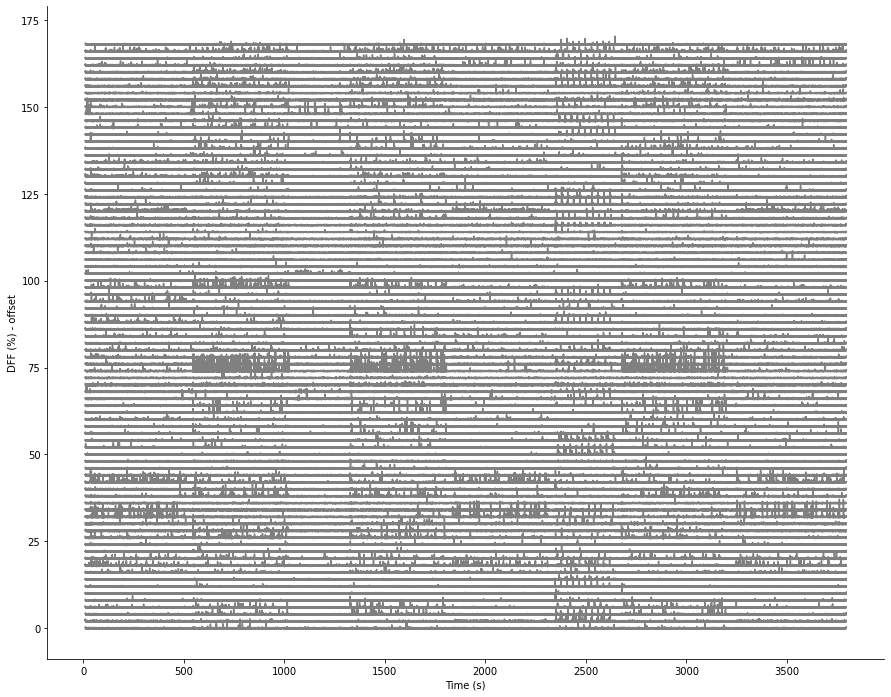

In [30]:
colors = ['blue','orange','green','red']

fig = plt.figure(figsize=(15,12))
for i in range(len(dff)):
    plt.plot(timestamps, dff[i,:]+(i*2), color='gray')
plt.xlabel("Time (s)")
plt.ylabel("DFF (%) - offset")
sns.despine()

          stimulus  start     end
0  static_gratings    738   15222
1  static_gratings  55054   69552
2  static_gratings  97616  113908


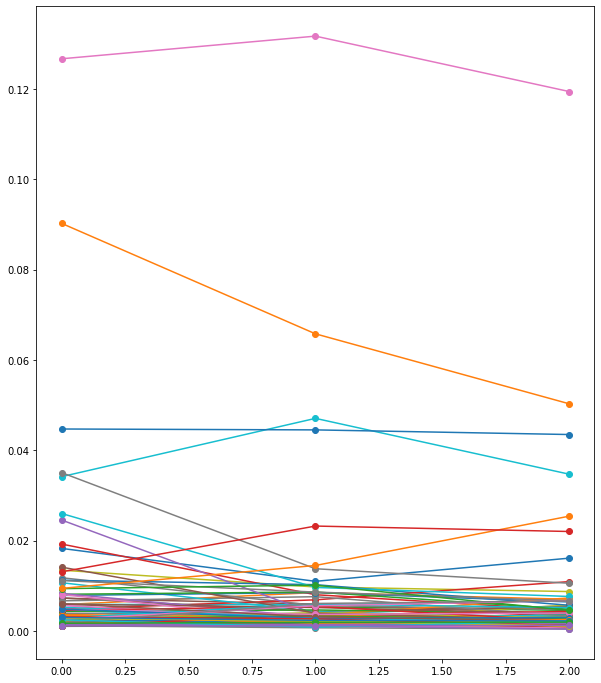

In [42]:
# plot mean response for stimulus exposure
static_gratings_epochs = stim_epochs.loc[stim_epochs["stimulus"] == "static_gratings"].reset_index(drop=True);

print(static_gratings_epochs)

# stim_epochs_mean_responses = np.empty(len(static_gratings_epochs.index))

# for index, epoch in static_gratings_epochs.iterrows():
#     stim_epochs_mean_responses[index] = dff_traces[:, int(epoch.start):int(epoch.end)].mean()
        
# plt.plot(stim_epochs_mean_responses, "-o")

fig = plt.figure(figsize=(10,12))

for dff_trace in dff_traces:
    stim_epochs_mean_responses = np.empty(len(static_gratings_epochs.index))

    for index, epoch in static_gratings_epochs.iterrows():
        stim_epochs_mean_responses[index] = dff_trace[int(epoch.start):int(epoch.end)].mean()
        
    plt.plot(stim_epochs_mean_responses, "-o")

In [ ]:
# CODE FOR SINGLE CELL

In [ ]:
# cell_ids = [541513580]
sessions= boc.get_ophys_experiments(stimuli=['static_gratings'], )
len(sessions)

In [40]:
data_set = boc.get_ophys_experiment_data(sessions[0]["id"])

In [41]:
cell_indices = data_set.get_cell_specimen_indices(cell_ids)

cell_indices

[213]

In [42]:
timestamps, dff = data_set.get_dff_traces() # get cell responses in the dataset

In [43]:
stim_table = data_set.get_stimulus_table("static_gratings")
# remove blank screen readings
stim_table = stim_table[stim_table["orientation"].isna() == False]

In [44]:
# get stimulus epochs
stim_epochs = data_set.get_stimulus_epoch_table()
stim_epochs

,stimulus,start,end
0,static_gratings,735,15216
1,natural_scenes,16122,30604
2,spontaneous,30754,39655
3,natural_scenes,39656,54137
4,static_gratings,55044,69525
5,natural_movie_one,70430,79483
6,natural_scenes,80388,96303
7,static_gratings,97586,113885


In [45]:
def get_dff_traces(cell_index, dff):
    return dff[cell_index][0]    

In [47]:
dff_traces = get_dff_traces(cell_indices[0], dff)

In [48]:
dff_traces.shape

()

Text(0, 0.5, 'DFF (%)')

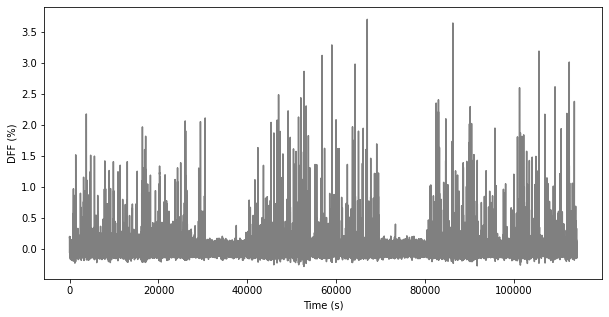

In [17]:
fig = plt.figure(figsize=(10,5))
plt.plot(dff_traces, color='gray')
plt.xlabel("Time (s)")
plt.ylabel("DFF (%)")

In [18]:
# get the cell's response per trial
response = pd.DataFrame(columns=('orientation','spatial_frequency','trial_response'), index=stim_table.index.values)

response['orientation'] = stim_table.orientation
response['spatial_frequency'] = stim_table.spatial_frequency

pd.options.mode.copy_on_write = True #this let's us write into the dataframe 

for ind,row_stim in stim_table.iterrows():
    response.loc[ind, 'trial_response'] = dff_traces[int(row_stim.start):int(row_stim.end)].mean()

In [19]:
response.head()

,orientation,spatial_frequency,trial_response
1,120.0,0.04,0.021273
2,0.0,0.02,0.000645
3,120.0,0.02,0.01941
4,30.0,0.32,0.015135
5,30.0,0.02,-0.043571


Text(0, 0.5, 'Mean DF/F')

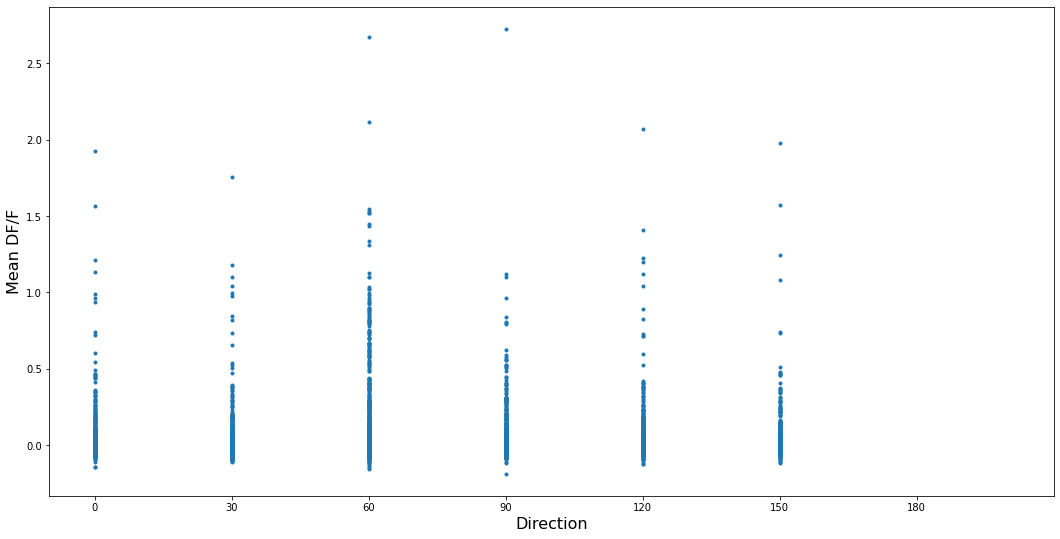

In [20]:
fig = plt.figure(figsize=(18,9))
plt.plot(response.orientation.values, response.trial_response.values, '.')
plt.xticks(range(0,210,30))
plt.xlim(-10,210)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

Text(0, 0.5, 'Mean DF/F')

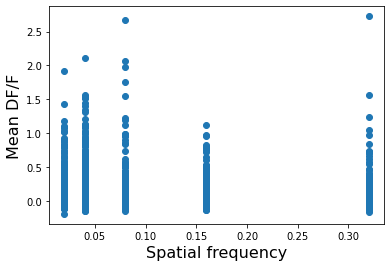

In [21]:
plt.plot(response.spatial_frequency.values, response.trial_response.values, 'o')
plt.xlabel("Spatial frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

In [22]:
# get unique orientations

all_ori = np.sort(stim_table.orientation.unique())
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  30.  60.  90. 120. 150.]


In [23]:
np.sort(stim_table.orientation.dropna().unique())

array([  0.,  30.,  60.,  90., 120., 150.], dtype=float32)

In [24]:
# orientation tuning

tuning = np.empty((6))
for i, ori in enumerate(orivals):
    trials = response[response.orientation==ori]
    tuning[i] = trials.trial_response.mean()
    #tuning[i] = response[response.orientation==ori].trial_response.mean()

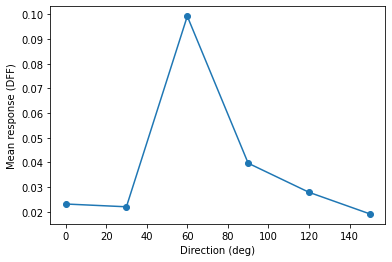

In [25]:
# plot tuning curve

plt.plot(orivals,tuning, 'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean response (DFF)")

tuning_std=np.empty(6)
for i, ori in enumerate (orivals):
    trials = response[response.orientation==ori]
    tuning_std[i]=trials.trial_response.std()

# plt.errorbar(orivals, tuning, yerr=tuning_std, fmt='o-')

<ErrorbarContainer object of 3 artists>

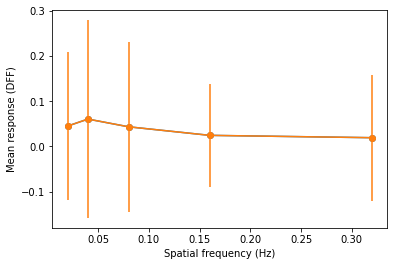

In [26]:
# tuning for spatial frequency

sfvals = np.sort(stim_table.spatial_frequency.unique())
sfvals = sfvals[np.isfinite(sfvals)]

tuning_sf = np.empty((len(sfvals)))
for i,sf in enumerate(sfvals):
    trials = response[response.spatial_frequency==sf]
    tuning_sf[i] = trials.trial_response.mean()
    
plt.plot(sfvals, tuning_sf, 'o-')
plt.xlabel("Spatial frequency (Hz)")
plt.ylabel("Mean response (DFF)")

tuning_std=np.empty(5)
for i, sf in enumerate (sfvals):
    trials = response[response.spatial_frequency==sf]
    tuning_std[i]=trials.trial_response.std()

plt.errorbar(sfvals, tuning_sf, yerr=tuning_std, fmt='o-')

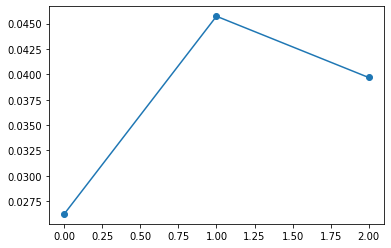

In [27]:
# plot mean response for stimulus exposure
static_gratings_epochs = stim_epochs.loc[stim_epochs["stimulus"] == "static_gratings"].reset_index(drop=True);

stim_epochs_mean_responses = np.empty(len(static_gratings_epochs.index))

for index, epoch in static_gratings_epochs.iterrows():
    stim_epochs_mean_responses[index] = dff_traces[int(epoch.start):int(epoch.end)].mean()
        
plt.plot(stim_epochs_mean_responses, "-o")